<a href="https://colab.research.google.com/github/PriyenduSingh/Quant-Trading-StockPricePredictor/blob/master/Quant_Trading_StockPricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First we will choose a company for stock price prediction
I choose L&T as its graph has many ups and downs and regression work good on it

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#Step 1: Data Extraction
def extract_data(symbol,start_date,end_date,interval):
  data=yf.download(symbol,start=start_date,end=end_date,interval=interval)
  return data

#Choosing L&T (LT) with a time frame of the past year and daily interval
start_date="2024-01-01"
end_date="2025-07-01"
symbol="LT.NS"
interval="1d"
data=extract_data(symbol,start_date,end_date,interval)
print("Date Shape;",data.shape)
print(data.head())


/tmp/ipython-input-300-1331357967.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(symbol,start=start_date,end=end_date,interval=interval)
[*********************100%***********************]  1 of 1 completed

Date Shape; (369, 5)
Price             Close         High          Low         Open   Volume
Ticker            LT.NS        LT.NS        LT.NS        LT.NS    LT.NS
Date                                                                   
2024-01-01  3465.631348  3477.968452  3436.730293  3477.968452   777080
2024-01-02  3379.763672  3465.631405  3373.767078  3465.238288  1511464
2024-01-03  3381.975586  3407.042912  3353.713405  3374.750202  1283859
2024-01-04  3400.013916  3421.050952  3364.919709  3382.663491  1651616
2024-01-05  3462.141357  3494.679823  3401.291754  3406.157716  2069018


#Calculation of Technical indicators  

#In this section, various technical indicators are calculated based on the extracted financial data of Infosys Limited.
#These indicators offer insights into the stock's price movements and potential trends.The following technical indicator are computed

1. Simple Moving Average (SMA) The Simple Moving Average (SMA) is calculated with a window of 20 days. It represents the average closing price of the stock over a specified period, smoothing out short-term fluctuations and highlighting longer-term trends.

2. Exponential Moving Average (EMA) The Exponential Moving Average (EMA) is computed with a window of 50 days. EMA gives more weight to recent prices, making it more responsive to price changes compared to SMA.

3. Moving Average Convergence Divergence (MACD) MACD is derived from two EMAs: a short-term EMA (12 days) and a long-term EMA (26 days). It indicates the relationship between these EMAs and helps identify potential trend reversals or momentum shifts.

4. Bollinger Bands Bollinger Bands consist of a middle band (SMA) and two outer bands that are standard deviations away from the middle band. They help identify potential overbought or oversold conditions and volatility changes.

5. Relative Strength Index (RSI) RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions. It is calculated based on the average gains and losses over a specified period (usually 14 days).

I have chosen these indicators as they were simple, very widely used across the internet and they fit well with the 5-day window I am using for buy, sell and hold.


In [ ]:
# Step 2: Calculate Technical Indicators
def calculate_sma(data, window=20):
    return data['Close'].rolling(window=window, min_periods=1).mean()

def calculate_ema(data, window=50):
    return data['Close'].ewm(span=window, adjust=False).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    sma = data['Close'].rolling(window=window, min_periods=1).mean()
    rolling_std = data['Close'].rolling(window=window, min_periods=1).std()

    # Apply forward fill and backward fill to handle NaN values
    sma = sma.ffill().bfill()
    rolling_std = rolling_std.ffill().bfill()

    upper_band = sma + (rolling_std * num_std_dev)
    lower_band = sma - (rolling_std * num_std_dev)

    return upper_band, lower_band


def calculate_rsi(data, window=14):
    delta = data['Close'].diff()

    # Apply forward fill and backward fill before rolling calculations
    delta = delta.ffill().bfill()

    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()

    # Apply forward fill and backward fill to handle NaN values after rolling calculations
    gain = gain.ffill().bfill()
    loss = loss.ffill().bfill()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
# Step 3: Create New Features
def create_features(data):
    data['SMA'] = calculate_sma(data)
    data['EMA'] = calculate_ema(data)
    data['SMA_50'] = calculate_sma(data, 50)
    data['EMA_12'] = calculate_ema(data, 12)
    data['MACD'], data['MACD_Signal'] = calculate_macd(data)
    data['Upper_Band'], data['Lower_Band'] = calculate_bollinger_bands(data, 20, 2)
    data['RSI'] = calculate_rsi(data)

    return data


#Construction of target variable

#The target variable is constructed in this step to facilitate the classification of buy, sell, or hold signals based on historical stock price data. This target variable will be used in subsequent steps for training and evaluating predictive models. The following procedure is employed to construct the target variable:   

Methodology Window Specification: A window of 5 days is chosen to compute the average closing price for the next five days.

Signal Determination:

For each day in the dataset, the closing price of the current day (today_close) is compared with the average closing price of the next five days (avg_next_five_days_close).

1. If the average closing price of the next five days is higher than the current day's closing price, a 'Buy' signal is generated.
2. If the average closing price of the next five days is lower than the current day's closing price, a 'Sell' signal is generated.
3. If there is no significant difference between the current day's closing price and the average closing price of the next five days, a 'Hold' signal is generated

In [ ]:
def construct_target_variable(data, window=5):
    signals = []
    for i in range(len(data) - window):
        today_close = data['Close'].iloc[i]

        # Use mean to convert Series to scalar
        avg_next_five_days = data['Close'].iloc[i+1:i+window+1].mean()

        if avg_next_five_days > today_close:
            signals.append('Buy')
        elif avg_next_five_days < today_close:
            signals.append('Sell')
        else:
            signals.append('Hold')

    # Add 'Hold' instead of integer
    signals.extend(['Hold'] * window)

    data['Signal'] = signals
    return data

# Visualization of Data with Signals
In this section, a function named plot_data_with_signals is defined to visualize the closing price of Infosys Limited's stock along with the corresponding signals ('Buy,' 'Sell,' or 'Hold') generated by the constructed target variable.

* Function: plot_data_with_signals This function plots the closing price of the stock over time and highlights the data points where signals are generated. The signals are represented by colored markers: green for 'Buy,' red for 'Sell,' and blue for 'Hold.'

In [ ]:
def plot_data_with_signals(data, signal='Signal', interval=5):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data.index, data['Close'], label='Close Price', color='black')

    for i in range(0, len(data), interval):
        sig = str(data[signal].iloc[i]).strip().lower()

        if sig == 'buy':
            ax.scatter(data.index[i], data['Close'].iloc[i], color='green', marker='^', s=100)
        elif sig == 'sell':
            ax.scatter(data.index[i], data['Close'].iloc[i], color='red', marker='v', s=100)
        else:
            ax.scatter(data.index[i], data['Close'].iloc[i], color='blue', marker='o', s=100)

    # Static legend
    ax.scatter([], [], color='green', marker='^', label='Buy')
    ax.scatter([], [], color='red', marker='v', label='Sell')
    ax.scatter([], [], color='blue', marker='o', label='Hold')

    ax.legend(loc='lower right')
    ax.set_title('Close Price with Buy/Sell/Hold Signals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#Logistic Regression Class Implementation Overview
1. Initialization The LogisticRegression class initializes the logistic regression object with parameters such as the learning rate (alpha) and the number of iterations (n_iterations). These parameters control the training process and optimization of the model.

2. Sigmoid Function The _sigmoid_function method computes the sigmoid transformation of the input data. The sigmoid function maps any real-valued number to a value between 0 and 1. It's utilized in logistic regression to transform the output of the linear equation into probabilities.

3. Cost Function The _cost_function method calculates the logistic loss, also known as the cross-entropy loss. This function measures the difference between the predicted probabilities and the actual labels. It quantifies how well the model is performing during training.

4. Gradient Descent The _gradient_descent method updates the model parameters (theta) using gradient descent. Gradient descent is an optimization algorithm that iteratively adjusts the parameters to minimize the cost function. It computes the gradient of the cost function with respect to each parameter and moves in the direction of the steepest descent.

5. Fitting the Model The fit method trains the logistic regression model on the provided training data. It iterates through unique labels and performs binary classification using the One-vs-All technique for multiclass classification tasks. During training, it optimizes the model parameters using gradient descent to minimize the cost function.

6. Prediction The predict method predicts the labels for the given input features using the trained model. It applies the learned parameters to the input data and computes the predicted labels based on the maximum probability among different classes.

7.Model Evaluation The score method evaluates the performance of the model by comparing the predicted labels with the actual labels. It calculates the accuracy of the model, which is the proportion of correctly predicted labels to the total number of samples.

In [ ]:
#We are importing all necessary libraries to implement our model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


class LogisticRegression(object):

    def __init__(Logreg, alpha=0.01, n_iteration=100):  #This function intializes the alpha value and iteration
        Logreg.alpha = alpha                            #value in the object
        Logreg.n_iter = n_iteration

    def _sigmoid_function(Logreg, x): #This function is resonsible for calculating the sigmoid value with given parameter
        value = 1 / (1 + np.exp(-x))
        return value
    def _cost_function(Logreg,h,theta, y): # The fuctions calculates the cost value
        m = len(y)
        cost = (1 / m) * (np.sum(-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))))
        return cost

    def _gradient_descent(Logreg,X,h,theta,y,m): # This function calculates the theta value by gradient descent
        gradient_value = np.dot(X.T, (h - y)) / m
        theta -= Logreg.alpha * gradient_value
        return theta

    def fit(Logreg, X, y): #This function primarily calculates the optimal theta value using which we predict the future data
        print("Fitting the given dataset..")
        Logreg.theta = []
        Logreg.cost = []
        X = np.insert(X, 0, 1, axis=1)
        m = len(y)
        for i in np.unique(y):
            #print('Descending the gradient for label type ' + str(i) + 'vs Rest')
            y_onevsall = np.where(y == i, 1, 0)
            theta = np.zeros(X.shape[1])
            cost = []
            for _ in range(Logreg.n_iter):
                z = X.dot(theta)
                h = Logreg._sigmoid_function(z)
                theta = Logreg._gradient_descent(X,h,theta,y_onevsall,m)
                cost.append(Logreg._cost_function(h,theta,y_onevsall))
            Logreg.theta.append((theta, i))
            Logreg.cost.append((cost,i))
        return Logreg

    def predict(Logreg, X): # this function calls the max predict function to classify the individul feauter
        X = np.insert(X, 0, 1, axis=1)
        X_predicted = [max((Logreg._sigmoid_function(i.dot(theta)), c) for theta, c in Logreg.theta)[1] for i in X ]

        return X_predicted

    def score(Logreg,X, y): #This function compares the predictd label with the actual label to find the model performance
        score = sum(Logreg.predict(X) == y) / len(y)
        return score

    def _plot_cost(Logreg,costh): # This function plot the Cost function value
        for cost,c in costh   :
                plt.plot(range(len(cost)),cost,'r')
                plt.title("Convergence Graph of Cost Function of type-" + str(c) +" vs All")
                plt.xlabel("Number of Iterations")
                plt.ylabel("Cost")
                plt.show()

In [ ]:
# Plot data with signals
def generate_signals(model, X):
  X_predicted = model.predict(X)
  return X_predicted

/tmp/ipython-input-300-1331357967.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(symbol,start=start_date,end=end_date,interval=interval)
[*********************100%***********************]  1 of 1 completed


Data preview:
Price             Close         High          Low         Open   Volume
Ticker            LT.NS        LT.NS        LT.NS        LT.NS    LT.NS
Date                                                                   
2024-01-01  3465.631348  3477.968452  3436.730293  3477.968452   777080
2024-01-02  3379.763672  3465.631405  3373.767078  3465.238288  1511464
2024-01-03  3381.975586  3407.042912  3353.713405  3374.750202  1283859
2024-01-04  3400.013916  3421.050952  3364.919709  3382.663491  1651616
2024-01-05  3462.141357  3494.679823  3401.291754  3406.157716  2069018
Columns: MultiIndex([( 'Close', 'LT.NS'),
            (  'High', 'LT.NS'),
            (   'Low', 'LT.NS'),
            (  'Open', 'LT.NS'),
            ('Volume', 'LT.NS')],
           names=['Price', 'Ticker'])
Price             Close         High          Low         Open   Volume  \
Date                                                                      
2024-01-01  3465.631348  3477.968452  3436.7302

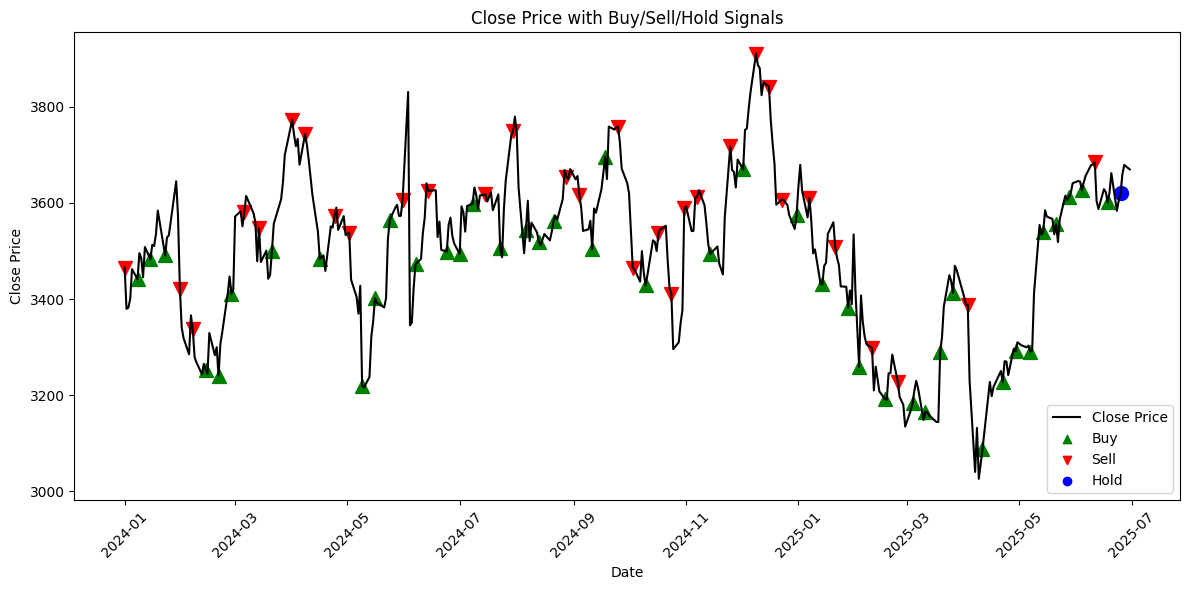

[[-0.21056117 -0.3685235  -0.16658034 ... -0.65200616  0.20891346
  -3.15245763]
 [-0.73243814 -0.44363897 -0.54680775 ... -0.95869755 -0.06941281
  -3.15245763]
 [-0.71899482 -0.80036148 -0.66790952 ... -1.2237859  -0.00483325
  -3.07361836]
 ...
 [ 0.96832046  0.79459318  0.94076826 ...  0.11731734  1.70358334
  -0.027449  ]
 [ 1.08744226  1.17452188  1.21191347 ...  0.15363708  1.69529473
  -0.05016503]
 [ 1.03031258  1.08989079  1.13763493 ...  0.17389854  1.69259525
  -0.12722638]]
Fitting the given dataset..
Accuracy is:  0.7049180327868853
Fitting the given dataset..
Accuracy is:  0.6721311475409836
Fitting the given dataset..
Accuracy is:  0.639344262295082
Fitting the given dataset..
Accuracy is:  0.6967213114754098
Fitting the given dataset..
Accuracy is:  0.6557377049180327
Fitting the given dataset..
Accuracy is:  0.6721311475409836
Fitting the given dataset..
Accuracy is:  0.6557377049180327
Fitting the given dataset..
Accuracy is:  0.680327868852459
Fitting the given data

In [ ]:
# Main Function
def main():
    # Step 1: Data Extraction
    data = extract_data(symbol, start_date, end_date, interval)


    print("Data preview:")
    print(data.head())
    print("Columns:", data.columns)
    data.columns = data.columns.droplevel(1)

    # Step 3: Feature Engineering
    data = create_features(data)

    # Step 4: Target Variable Construction
    data = construct_target_variable(data)

    return data  # Return the modified data DataFrame

if __name__ == "__main__":
    modified_data = main()  # Assign the returned modified data DataFrame to a variable
    print(modified_data.head())  # Print the modified data DataFrame

    plot_data_with_signals(modified_data, signal='Signal', interval=5)

    y_data = modified_data['Signal'].values
    X = modified_data.drop(['Signal'], axis=1).values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print(X)

    # Import train_test_split
    from sklearn.model_selection import train_test_split

    # Train the logistic regression model multiple times and select the best model
    best_model = None
    best_accuracy = 0
    for _ in range(15):
        X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.33)
        logi = LogisticRegression(n_iteration=30000).fit(X_train, y_train)
        accuracy = logi.score(X_test, y_test)
        print("Accuracy is: ", accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = logi

    print("The best accuracy of the model is ", best_accuracy)

    # Generate signals using the best model
    signals = generate_signals(best_model, X)

    # Calculate F1 score
    f1 = f1_score(y_test, best_model.predict(X_test), average='weighted')
    print("F1 Score:", f1)

In [ ]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
!git add .


In [ ]:
!git commit -m "Initial commit of ML code"


Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@a43c52a194e4.(none)')


In [6]:
!git config --global user.email "priyendusingh000@gmail.com"


In [7]:
!git config --global user.name "PriyenduSingh"

In [8]:
!git commit -m "Initial commit of ML code"


[master (root-commit) 274634c] Initial commit of ML code
 21 files changed, 51025 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.10.22/13.37.51.566274.log
 create mode 100644 .config/logs/2025.10.22/13.38.25.983338.log
 create mode 100644 .config/logs/2025.10.22/13.38.34.894138.log
 create mode 100644 .config/logs/2025.10.22/13.38.40.152011.log
 create mode 100644 .config/logs/2025.10.22/13.38.48.808237.log
 create mode 100644 .config/logs/2025.10.22/13.38.49.564834.log
 create mode 100755 sample_data/README.md
 creat